# Analyse Störliste – Blatt „Aufschreibung“

Dieses Notebook:
1. lädt die Excel-Datei,
2. entfernt alle **leeren Zeilen**, die **ab der Spalte „Dauer Org-Mangel“** (und alle folgenden Spalten) **keine Daten** enthalten,
3. bereitet Zeit-/Dauerfelder auf und
4. analysiert **Stoßzeiten**, **Maschinen/Stationen** und **Fehlerursachen** inkl. Auffälligkeiten bei der **Ausfalldauer**.


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datei-Pfad (im gleichen Ordner wie das Notebook oder anpassen)
FILE_PATH = "../data/raw/Störliste STW-Mittelteilanlage 2023_NEU.xlsx"
SHEET_NAME = "Aufschreibung"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)



In [2]:
# --- Laden ---
df_raw = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

print("Rohdaten:", df_raw.shape)
display(df_raw.head(3))


Rohdaten: (7776, 37)


,Datum,Wochentag,DatumNEU,KW,Std.,Log,Schicht,Zeit von,Zeit bis,Dauer\nArbeits-zeit,Anzahl MA,Menge N.i. O.,Menge i. O. L4,Menge i. O. L5,Menge Gesamt\n(Stück),Dauer \nOrg-Mangel,Dauer\nAnlagen-Ausfall\n,Störung aufgrund Vormaterial,Dauer\nAnlagen-Ausfall\nintern,Dauer\nLogistik-\nDefizite,Station/ OP,Bemerkung\n,Anzahl/Std.,Fehlercode,Sollzeit\n/ Stück\n(Min),Takt \nGesamt,Leistung\nSollzeit zu Gesamtzeit,Anlagen-Laufzeit\n(- Org-Mangel),Takt \nGesamt2,Leistung\nAnlage inkl. \nAnl. ausfall,Anlagen-Laufzeit\n(- Anlagen-ausfall),Takt \nGesamt3,Leistung eff.\nAnlage ohne\nAnl.-Ausfall,Produktionszeit(min)/Std.,Takt \nGesamt4,Leistung\n inkl.\ndefizite,Unnamed: 36
0,NaT,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,7.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,20.0,NaN,NaN,Wartungsplan,NaN,NaN,8.5,15.0,0.566667,60.0,15.0,0.566667,40.0,10.0,0.85,40.0,10.0,0.85,0.0
2,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,7.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
# --- Spaltennamen normalisieren (Zeilenumbrüche/Mehrfachspaces entfernen) ---
df = df_raw.copy()
df.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in df.columns]

# Zielspalte finden (robust, falls in Excel Zeilenumbrüche/Spaces anders sind)
target_pattern = re.compile(r"^Dauer\s*Org-?Mangel$", re.IGNORECASE)
start_col = None
for c in df.columns:
    if target_pattern.match(c):
        start_col = c
        break

if start_col is None:
    # Fallback: suche nach beiden Wörtern
    candidates = [c for c in df.columns if ("Dauer" in c) and ("Org" in c) and ("Mangel" in c)]
    if candidates:
        start_col = candidates[0]

if start_col is None:
    raise ValueError("Spalte 'Dauer Org-Mangel' konnte nicht gefunden werden. Bitte Spaltennamen prüfen.")

start_idx = list(df.columns).index(start_col)
cols_from = list(df.columns)[start_idx:]

print("Startspalte:", start_col)
print("Spalten ab Startspalte:", cols_from)


Startspalte: Dauer Org-Mangel
Spalten ab Startspalte: ['Dauer Org-Mangel', 'Dauer Anlagen-Ausfall', 'Störung aufgrund Vormaterial', 'Dauer Anlagen-Ausfall intern', 'Dauer Logistik- Defizite', 'Station/ OP', 'Bemerkung', 'Anzahl/Std.', 'Fehlercode', 'Sollzeit / Stück (Min)', 'Takt Gesamt', 'Leistung Sollzeit zu Gesamtzeit', 'Anlagen-Laufzeit (- Org-Mangel)', 'Takt Gesamt2', 'Leistung Anlage inkl. Anl. ausfall', 'Anlagen-Laufzeit (- Anlagen-ausfall)', 'Takt Gesamt3', 'Leistung eff. Anlage ohne Anl.-Ausfall', 'Produktionszeit(min)/Std.', 'Takt Gesamt4', 'Leistung inkl. defizite', 'Unnamed: 36']


In [4]:
# --- Leere Zeilen entfernen: wenn ab Startspalte (inkl.) ALLES leer ist ---
df_clean = df.copy()

# Leere Strings -> NA (nur in object/string-Spalten)
for c in cols_from:
    if df_clean[c].dtype == object:
        df_clean[c] = df_clean[c].astype("string").str.strip()
        df_clean.loc[df_clean[c].isin(["", "nan", "NaN"]), c] = pd.NA

mask_keep = df_clean[cols_from].notna().any(axis=1)
df_clean = df_clean.loc[mask_keep].copy()

print("Nach dem Entfernen leerer Zeilen:", df_clean.shape)
display(df_clean.head(5))


Nach dem Entfernen leerer Zeilen: (7763, 37)


,Datum,Wochentag,DatumNEU,KW,Std.,Log,Schicht,Zeit von,Zeit bis,Dauer Arbeits-zeit,Anzahl MA,Menge N.i. O.,Menge i. O. L4,Menge i. O. L5,Menge Gesamt (Stück),Dauer Org-Mangel,Dauer Anlagen-Ausfall,Störung aufgrund Vormaterial,Dauer Anlagen-Ausfall intern,Dauer Logistik- Defizite,Station/ OP,Bemerkung,Anzahl/Std.,Fehlercode,Sollzeit / Stück (Min),Takt Gesamt,Leistung Sollzeit zu Gesamtzeit,Anlagen-Laufzeit (- Org-Mangel),Takt Gesamt2,Leistung Anlage inkl. Anl. ausfall,Anlagen-Laufzeit (- Anlagen-ausfall),Takt Gesamt3,Leistung eff. Anlage ohne Anl.-Ausfall,Produktionszeit(min)/Std.,Takt Gesamt4,Leistung inkl. defizite,Unnamed: 36
0,NaT,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,0.0
1,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,7.0,NaN,NaN,4.0,4.0,<NA>,<NA>,NaN,20.0,NaN,NaN,Wartungsplan,NaN,NaN,8.5,15.0,0.5666666666666763,60.0,15.0,0.5666666666666763,40.0,10.0,0.8500000000000216,40.0,10.0,0.8500000000000216,0.0
2,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,7.0,NaN,NaN,4.0,4.0,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,0.0
3,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,07:00:00,08:00:00,60.0,7.0,NaN,NaN,4.0,4.0,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,0.0
4,2023-01-03,2,2023-01-03,2023/01,NaT,NaT,t,08:00:00,09:00:00,60.0,7.0,1.0,NaN,4.0,5.0,<NA>,<NA>,NaN,10.0,NaN,OP 50,"BMB spanner einstellen, Anlage LEER",NaN,NaN,8.5,12.0,0.7083333333333274,60.0,12.0,0.7083333333333274,50.0,10.0,0.8499999999999914,50.0,10.0,0.8499999999999914,0.0


In [22]:
# --- Alle Varianten aus "Bemerkung" alphabetisch sammeln ---

df_clean["Bemerkung"] = (
    df_clean["Bemerkung"]
    .astype("string")
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# "Bemerkung" bereinigen: Zeilenumbrüche/Mehrfachspaces -> 1 Space, trimmen
bem = df_clean["Bemerkung"].astype("string")
bem_norm = (
    bem
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# NaNs sichtbar machen (sonst gehen sie ggf. unter)
bem_norm = bem_norm.fillna("<NA>")

# Alphabetische Liste + Counts
bem_counts = (
    bem_norm
    .value_counts(dropna=False)
    .sort_index()  # alphabetisch nach dem Wert
    .reset_index()
    .rename(columns={"index": "Bemerkung", "count": "Anzahl"})
)

display(bem_counts)
print(f"Anzahl verschiedener Varianten: {bem_counts.shape[0]}")

,Bemerkung,Anzahl
0,(draht komplett klebrig/drahtseele verstopft/k...,1
1,.wb-24. suchen,1
2,/anlagenbereich reinigen/wochenplan,1
3,/bleche einlagern,1
4,/r05 vakuum,1
...,...,...
701,zündfehler gas und stromdüse getauscht,1
702,zündfehler ohne meldung / robotertechniker inf...,1
703,zündfehler schweißt an stromdüse fest,1
704,zündfehler zu wenig gas / brenner getauscht,1


Anzahl verschiedener Varianten: 706


In [15]:
import unicodedata

def normalize_text(s: pd.Series) -> pd.Series:
    s = s.astype("string")

    # unicode vereinheitlichen (z.B. verschiedene Bindestriche)
    s = s.map(lambda x: unicodedata.normalize("NFKC", x) if pd.notna(x) else x)

    # lower, trim
    s = s.str.lower().str.strip()

    # zeilenumbrüche / tabs / mehrfachspaces
    s = s.str.replace(r"\s+", " ", regex=True)

    # bindestrich-varianten vereinheitlichen
    s = s.str.replace(r"[‐-‒–—―]", "-", regex=True)

    # optional: Satzzeichen entschärfen (vorsichtig)
    s = s.str.replace(r"[•·●]", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()

    # leere zu NA
    s = s.replace({"": pd.NA, "nan": pd.NA})
    return s

df_clean["Bemerkung_norm"] = normalize_text(df_clean["Bemerkung"])


REPLACEMENTS = {
    "k.a.": pd.NA,
    "keine": pd.NA,
    "o.k.": "ok",
    "i.o.": "ok",
    "n. i. o.": "nicht ok",
    "n.i.o": "nicht ok",
    "defekt": "defekt",
    "def.": "defekt",
}

df_clean["Bemerkung_std"] = df_clean["Bemerkung_norm"].replace(REPLACEMENTS)



In [5]:
# Optional: bereinigte Daten speichern
df_clean.to_csv("../data/processed/aufschreibung_mta_clean.csv", index=False)
df_clean.to_excel("../data/processed/aufschreibung_mta_clean.xlsx", index=False)

print("Bereinigte Daten gespeichert! :D")


Bereinigte Daten gespeichert! :D


In [ ]:
from pandas.api.types import (
    is_numeric_dtype, is_datetime64_any_dtype, is_bool_dtype, is_categorical_dtype
)

def profile_dataframe(df: pd.DataFrame, top_n_values: int = 3) -> pd.DataFrame:
    rows = []
    n_rows = len(df)

    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)

        missing = int(s.isna().sum())
        non_null = int(n_rows - missing)
        missing_pct = float(missing / n_rows * 100) if n_rows else np.nan

        # Empty-string count (nur sinnvoll für objektartige Spalten)
        empty_str = np.nan
        if s.dtype == "object" or is_categorical_dtype(s):
            s_str = s.astype("string")
            empty_str = int(s_str.fillna("").str.strip().eq("").sum())

        nunique = int(s.nunique(dropna=True))

        # Most frequent value
        top_val, top_freq, top_share = (np.nan, np.nan, np.nan)
        vc = s.value_counts(dropna=True)
        if len(vc) > 0:
            top_val = vc.index[0]
            top_freq = int(vc.iloc[0])
            top_share = float(top_freq / non_null * 100) if non_null else np.nan

        # Defaults for stats
        min_v = max_v = mean_v = median_v = std_v = p01 = p99 = np.nan
        zeros = negatives = infs = outliers_iqr = np.nan
        avg_len = max_len = min_len = np.nan
        num_parse_share = dt_parse_share = np.nan

        # Numeric stats
        if is_numeric_dtype(s):
            x = pd.to_numeric(s, errors="coerce")
            infs = int(np.isinf(x).sum()) if x.notna().any() else 0
            x = x.replace([np.inf, -np.inf], np.nan).dropna()

            if len(x) > 0:
                min_v = float(x.min())
                max_v = float(x.max())
                mean_v = float(x.mean())
                median_v = float(x.median())
                std_v = float(x.std(ddof=1)) if len(x) > 1 else 0.0
                p01 = float(x.quantile(0.01))
                p99 = float(x.quantile(0.99))
                zeros = int((x == 0).sum())
                negatives = int((x < 0).sum())

                q1 = float(x.quantile(0.25))
                q3 = float(x.quantile(0.75))
                iqr = q3 - q1
                if iqr > 0:
                    lo = q1 - 1.5 * iqr
                    hi = q3 + 1.5 * iqr
                    outliers_iqr = int(((x < lo) | (x > hi)).sum())
                else:
                    outliers_iqr = 0

        # Datetime stats
        elif is_datetime64_any_dtype(s):
            x = pd.to_datetime(s, errors="coerce")
            x = x.dropna()
            if len(x) > 0:
                min_v = x.min()
                max_v = x.max()
                # mean/median bei datetime sind nicht immer sinnvoll -> lassen wir leer

        # Boolean stats
        elif is_bool_dtype(s):
            # min/max/mean/median sind hier nicht so sinnvoll; kannst du aber ergänzen
            pass

        # Object/categorical: string-y stats + parseability hints
        else:
            s_str = s.astype("string")
            # Längen (ohne NaN)
            s_nonnull = s_str.dropna()
            if len(s_nonnull) > 0:
                lens = s_nonnull.str.len()
                avg_len = float(lens.mean())
                max_len = float(lens.max())
                min_len = float(lens.min())

            # "Kann man das eigentlich als Zahl/Datum lesen?"
            # (hilft, um falsch typisierte Spalten zu entdecken)
            num_parse_share = float(pd.to_numeric(s_str, errors="coerce").notna().mean() * 100) if n_rows else np.nan
            dt_parse_share = float(pd.to_datetime(s_str, errors="coerce", dayfirst=True).notna().mean() * 100) if n_rows else np.nan

        # Small sample of values
        examples = ", ".join(map(str, s.dropna().unique()[:top_n_values])) if non_null else ""

        constant_col = (nunique == 1 and non_null > 0)
        very_sparse = (missing_pct >= 80)

        rows.append({
            "column": col,
            "dtype": dtype,
            "rows": n_rows,
            "non_null": non_null,
            "missing": missing,
            "missing_%": round(missing_pct, 2),
            "empty_str_count": empty_str,
            "unique_non_null": nunique,
            "top_value": top_val,
            "top_freq": top_freq,
            "top_share_%": round(top_share, 2) if pd.notna(top_share) else np.nan,

            # numeric/datetime stats where applicable
            "min": min_v,
            "max": max_v,
            "mean": mean_v,
            "median": median_v,
            "std": std_v,
            "p01": p01,
            "p99": p99,
            "zeros": zeros,
            "negatives": negatives,
            "infs": infs,
            "outliers_iqr": outliers_iqr,

            # text stats where applicable
            "avg_len": avg_len,
            "min_len": min_len,
            "max_len": max_len,
            "numeric_parseable_%": round(num_parse_share, 2) if pd.notna(num_parse_share) else np.nan,
            "datetime_parseable_%": round(dt_parse_share, 2) if pd.notna(dt_parse_share) else np.nan,

            # flags + examples
            "constant_col": constant_col,
            "very_sparse_(>=80%_missing)": very_sparse,
            "example_values": examples
        })

    prof = pd.DataFrame(rows)

    # Optional: hübsch sortieren
    prof = prof.sort_values(["missing_%", "unique_non_null"], ascending=[False, False]).reset_index(drop=True)
    return prof

profile = profile_dataframe(df_clean, top_n_values=3)
display(profile)

# Optional Export
# profile.to_excel("df_cleaned_profile.xlsx", index=False)

In [31]:

from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

# =========================
# Einstellungen / Thresholds
# =========================
TH_SPARSE_MISSING_PCT = 80.0
TH_HIGH_MISSING_PCT   = 20.0
TH_PARSEABLE_PCT      = 70.0          # object -> numerisch/datetime parsebar
TH_OUTLIER_IQR        = 50            # Anzahl IQR-Outlier als Flag
TH_NEGATIVES          = 1
TH_HEAP_10_PCT        = 60.0          # % Werte teilbar durch 10 (Rundungs-/Heaping-Effekt)
TH_COMMON_VALUE_PCT   = 25.0          # häufigster einzelner Wert (z.B. 60) bei Numerik
TH_CASE_WS_VARIANTS_RATIO = 0.15      # Anteil "vermeidbarer" Varianten durch Lower/Strip/WS

def _safe_series_str(s: pd.Series) -> pd.Series:
    return s.astype("string")

def _normalize_text_series(s: pd.Series) -> pd.Series:
    # lower + strip + multiple spaces -> 1 space
    ss = _safe_series_str(s)
    return (
        ss.fillna("")
          .str.strip()
          .str.lower()
          .str.replace(r"\s+", " ", regex=True)
    )

def _try_profile(df: pd.DataFrame) -> pd.DataFrame:
    """Falls 'profile' aus der ersten Zelle nicht existiert, bauen wir hier ein light-Profil."""
    rows = []
    n = len(df)
    for c in df.columns:
        s = df[c]
        miss = int(s.isna().sum())
        non_null = n - miss
        miss_pct = (miss / n * 100) if n else np.nan
        nunique = int(s.nunique(dropna=True))
        top_val = top_freq = top_share = np.nan
        vc = s.value_counts(dropna=True)
        if len(vc) > 0:
            top_val = vc.index[0]
            top_freq = int(vc.iloc[0])
            top_share = float(top_freq / non_null * 100) if non_null else np.nan

        min_v = max_v = mean_v = median_v = std_v = p01 = p99 = np.nan
        zeros = negatives = infs = outliers_iqr = np.nan
        avg_len = min_len = max_len = np.nan
        num_parse_share = dt_parse_share = np.nan
        empty_str = np.nan

        if is_numeric_dtype(s):
            x = pd.to_numeric(s, errors="coerce")
            infs = int(np.isinf(x).sum()) if x.notna().any() else 0
            x = x.replace([np.inf, -np.inf], np.nan).dropna()
            if len(x) > 0:
                min_v = float(x.min()); max_v = float(x.max())
                mean_v = float(x.mean()); median_v = float(x.median())
                std_v = float(x.std(ddof=1)) if len(x) > 1 else 0.0
                p01 = float(x.quantile(0.01)); p99 = float(x.quantile(0.99))
                zeros = int((x == 0).sum()); negatives = int((x < 0).sum())
                q1 = float(x.quantile(0.25)); q3 = float(x.quantile(0.75))
                iqr = q3 - q1
                if iqr > 0:
                    lo = q1 - 1.5 * iqr; hi = q3 + 1.5 * iqr
                    outliers_iqr = int(((x < lo) | (x > hi)).sum())
                else:
                    outliers_iqr = 0

        elif is_datetime64_any_dtype(s):
            x = pd.to_datetime(s, errors="coerce").dropna()
            if len(x) > 0:
                min_v = x.min()
                max_v = x.max()

        else:
            ss = _safe_series_str(s)
            empty_str = int(ss.fillna("").str.strip().eq("").sum())
            nonnull = ss.dropna()
            if len(nonnull) > 0:
                lens = nonnull.str.len()
                avg_len = float(lens.mean()); min_len = float(lens.min()); max_len = float(lens.max())
            num_parse_share = float(pd.to_numeric(ss, errors="coerce").notna().mean() * 100) if n else np.nan
            dt_parse_share = float(pd.to_datetime(ss, errors="coerce", dayfirst=True).notna().mean() * 100) if n else np.nan

        rows.append({
            "column": c, "dtype": str(s.dtype), "rows": n, "non_null": non_null,
            "missing": miss, "missing_%": float(miss_pct),
            "empty_str_count": empty_str, "unique_non_null": nunique,
            "top_value": top_val, "top_freq": top_freq, "top_share_%": float(top_share) if pd.notna(top_share) else np.nan,
            "min": min_v, "max": max_v, "mean": mean_v, "median": median_v, "std": std_v, "p01": p01, "p99": p99,
            "zeros": zeros, "negatives": negatives, "infs": infs, "outliers_iqr": outliers_iqr,
            "avg_len": avg_len, "min_len": min_len, "max_len": max_len,
            "numeric_parseable_%": num_parse_share, "datetime_parseable_%": dt_parse_share,
        })
    return pd.DataFrame(rows)

def build_cleaning_todo(df: pd.DataFrame, profile_df: pd.DataFrame | None = None):
    if profile_df is None:
        profile_df = _try_profile(df)

    issues = []

    # ---- 1) Missingness / Constant cols / Empty strings
    for _, r in profile_df.iterrows():
        col = r["column"]
        dtype = r["dtype"]
        miss_pct = r.get("missing_%", np.nan)
        nunique = r.get("unique_non_null", np.nan)
        empty_str = r.get("empty_str_count", np.nan)

        if pd.notna(miss_pct) and miss_pct >= TH_SPARSE_MISSING_PCT:
            issues.append((col, "very_sparse", "HIGH",
                           f"{miss_pct:.1f}% Missing",
                           "Prüfen ob Spalte überhaupt gebraucht wird; ggf. droppen oder Datenquelle fixen."))

        elif pd.notna(miss_pct) and miss_pct >= TH_HIGH_MISSING_PCT:
            issues.append((col, "missing_values", "MEDIUM",
                           f"{miss_pct:.1f}% Missing",
                           "Imputation/Default definieren oder Analyse mit Missing-Indikator ergänzen."))

        if pd.notna(nunique) and nunique == 1 and int(r.get("non_null", 0)) > 0:
            issues.append((col, "constant_column", "MEDIUM",
                           "nur 1 eindeutiger Wert",
                           "Für Modelle/Analysen meist droppbar."))

        if pd.notna(empty_str) and empty_str > 0:
            issues.append((col, "empty_strings", "LOW",
                           f"{int(empty_str)} leere Strings (''/nur Spaces)",
                           "Leere Strings zu NaN vereinheitlichen: df[col].replace(r'^\\s*$', np.nan, regex=True)."))

        # ---- 2) Object-Spalten, die eigentlich Zahl/Datum sind
        num_parse = r.get("numeric_parseable_%", np.nan)
        dt_parse  = r.get("datetime_parseable_%", np.nan)
        if ("object" in dtype.lower() or "string" in dtype.lower() or "category" in dtype.lower()):
            if pd.notna(num_parse) and num_parse >= TH_PARSEABLE_PCT:
                issues.append((col, "type_suspect_numeric", "HIGH",
                               f"{num_parse:.1f}% als Zahl parsebar",
                               "Typ korrigieren: pd.to_numeric(...). Prüfen auf Tausendertrennzeichen/Kommas."))
            if pd.notna(dt_parse) and dt_parse >= TH_PARSEABLE_PCT:
                issues.append((col, "type_suspect_datetime", "HIGH",
                               f"{dt_parse:.1f}% als Datum parsebar",
                               "Typ korrigieren: pd.to_datetime(..., dayfirst=True)."))

    # ---- 3) Numeric: Negative, Ausreißer, Heaping (Rundung auf 10/5), “60-Minuten-Effekt” etc.
    for c in df.columns:
        s = df[c]
        if not is_numeric_dtype(s):
            continue

        x = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
        if len(x) == 0:
            continue

        neg = int((x < 0).sum())
        if neg >= TH_NEGATIVES:
            issues.append((c, "negatives_in_numeric", "HIGH",
                           f"{neg} negative Werte",
                           "Plausibilität prüfen (sollte das <0 sein?). Ggf. korrigieren oder filtern."))

        # IQR Outliers
        q1, q3 = float(x.quantile(0.25)), float(x.quantile(0.75))
        iqr = q3 - q1
        if iqr > 0:
            lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
            out_n = int(((x < lo) | (x > hi)).sum())
            if out_n >= TH_OUTLIER_IQR:
                issues.append((c, "many_outliers_iqr", "MEDIUM",
                               f"{out_n} IQR-Outlier",
                               "Ausreißer prüfen: Eingabefehler vs echte extreme Events; ggf. winsorize/cap oder separate Analyse."))

        # Heaping: Anteil teilbar durch 10 (bei integer-like Daten)
        # Wir prüfen nur, wenn viele Werte nahe ganzzahlig sind
        frac_part = np.abs(x - np.round(x))
        integer_like_share = float((frac_part < 1e-9).mean() * 100)

        if integer_like_share >= 80:
            mod10_share = float((x.astype(int) % 10 == 0).mean() * 100)
            if mod10_share >= TH_HEAP_10_PCT:
                issues.append((c, "rounding_heaping", "LOW",
                               f"{mod10_share:.1f}% der Werte sind durch 10 teilbar (integer-like {integer_like_share:.1f}%)",
                               "Kann auf Rundung/Block-Erfassung hindeuten (z.B. 60-min). Für Prognose evtl. ok, aber Interpretation vorsichtig."))

        # “common single value dominates” (z.B. 60)
        vc = x.value_counts(normalize=True)
        if len(vc) > 0:
            top_val = vc.index[0]
            top_share = float(vc.iloc[0] * 100)
            if top_share >= TH_COMMON_VALUE_PCT:
                issues.append((c, "dominant_value", "LOW",
                               f"Häufigster Wert {top_val} macht {top_share:.1f}% aus",
                               "Prüfen ob erfasst/gerundet (z.B. 60, 0). Eventuell Separate Analyse für diese Klasse."))

    # ---- 4) Text-Konsistenz: Case/Whitespace Varianten
    for c in df.columns:
        s = df[c]
        if is_numeric_dtype(s) or is_datetime64_any_dtype(s):
            continue

        ss = _safe_series_str(s)
        nonnull = ss.dropna()
        if len(nonnull) < 30:
            continue

        raw_unique = int(nonnull.nunique())
        norm = _normalize_text_series(nonnull)
        norm_unique = int(norm[norm != ""].nunique())

        if raw_unique > 0:
            avoidable_ratio = (raw_unique - norm_unique) / raw_unique if raw_unique else 0.0
            if avoidable_ratio >= TH_CASE_WS_VARIANTS_RATIO and raw_unique >= 20:
                issues.append((c, "text_variants_case_ws", "MEDIUM",
                               f"Raw unique={raw_unique}, normalized unique={norm_unique} (vermeidbare Varianten ~{avoidable_ratio*100:.1f}%)",
                               "Empfehlung: lower()+strip()+spaces normalisieren; optional Mapping-Tabelle für Synonyme."))

        # High cardinality flag
        if raw_unique > 0:
            uniq_ratio = raw_unique / len(nonnull)
            if raw_unique >= 200 and uniq_ratio > 0.5:
                issues.append((c, "high_cardinality_text", "MEDIUM",
                               f"sehr hohe Kardinalität: {raw_unique} unique bei {len(nonnull)} Werten",
                               "Kann Freitext/IDs sein. Für Modelle: bucketing, TF-IDF/Clustering oder auf Kategorie reduzieren."))

    # ---- 5) Duplicate columns (identische Inhalte) – quick hash approach
    # Achtung: kann bei großen DF dauern; hier aber i.d.R. ok.
    try:
        col_hash = {}
        for c in df.columns:
            # normalize representation
            h = pd.util.hash_pandas_object(df[c].astype("string"), index=False).sum()
            col_hash.setdefault(h, []).append(c)

        dups = [cols for cols in col_hash.values() if len(cols) > 1]
        for group in dups:
            issues.append((", ".join(group), "duplicate_columns", "LOW",
                           f"{len(group)} Spalten scheinen identisch",
                           "Prüfen und redundante Spalten droppen (oder eine als Quelle behalten)."))
    except Exception as e:
        issues.append(("__DATAFRAME__", "duplicate_columns_check_failed", "LOW",
                       str(e), "Duplicate-Check übersprungen."))

    issues_df = pd.DataFrame(issues, columns=["column", "issue_type", "severity", "details", "recommendation"])

    # Severity Sort
    sev_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
    issues_df["_sev"] = issues_df["severity"].map(sev_order).fillna(9).astype(int)
    issues_df = issues_df.sort_values(["_sev", "column", "issue_type"]).drop(columns=["_sev"]).reset_index(drop=True)

    # "To-Do Liste" als Text je Spalte
    todo = (
        issues_df.groupby("column")
        .apply(lambda g: "\n".join([f"- [{row.severity}] {row.issue_type}: {row.details} → {row.recommendation}"
                                   for _, row in g.iterrows()]))
        .rename("todo")
        .reset_index()
        .sort_values("column")
        .reset_index(drop=True)
    )

    return issues_df, todo

# =========================
# Run
# =========================
df = df_clean  

# falls profile aus der vorherigen Zelle existiert, nutze es
profile_df = globals().get("profile", None)
issues_df, todo_df = build_cleaning_todo(df, profile_df=profile_df)

print("Auffälligkeiten gefunden:", len(issues_df))
display(issues_df)

print("\nTo-Do Liste pro Spalte:")
display(todo_df)

# Optional: Export
# issues_df.to_excel("df_cleaned_issues.xlsx", index=False)
# todo_df.to_excel("df_cleaned_todo.xlsx", index=False)

C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_42848\2774665134.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_parse_share = float(pd.to_datetime(ss, errors="coerce", dayfirst=True).notna().mean() * 100) if n else np.nan
C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_42848\2774665134.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_parse_share = float(pd.to_datetime(ss, errors="coerce", dayfirst=True).notna().mean() * 100) if n else np.nan
C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_42848\2774665134.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

Auffälligkeiten gefunden: 85


,column,issue_type,severity,details,recommendation
0,Anlagen-Laufzeit (- Anlagen-ausfall),negatives_in_numeric,HIGH,22 negative Werte,Plausibilität prüfen (sollte das <0 sein?). Gg...
1,Anlagen-Laufzeit (- Org-Mangel),negatives_in_numeric,HIGH,7 negative Werte,Plausibilität prüfen (sollte das <0 sein?). Gg...
2,Anzahl/Std.,very_sparse,HIGH,99.1% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
3,Dauer Anlagen-Ausfall,very_sparse,HIGH,89.3% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
4,Dauer Anlagen-Ausfall intern,very_sparse,HIGH,95.9% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
...,...,...,...,...,...
80,Unnamed: 36,dominant_value,LOW,Häufigster Wert 0.0 macht 97.4% aus,"Prüfen ob erfasst/gerundet (z.B. 60, 0). Event..."
81,Unnamed: 36,rounding_heaping,LOW,97.4% der Werte sind durch 10 teilbar (integer...,Kann auf Rundung/Block-Erfassung hindeuten (z....
82,Wochentag,empty_strings,LOW,18 leere Strings (''/nur Spaces),Leere Strings zu NaN vereinheitlichen: df[col]...
83,Zeit bis,empty_strings,LOW,1 leere Strings (''/nur Spaces),Leere Strings zu NaN vereinheitlichen: df[col]...



To-Do Liste pro Spalte:


,column,todo
0,Anlagen-Laufzeit (- Anlagen-ausfall),- [HIGH] negatives_in_numeric: 22 negative Wer...
1,Anlagen-Laufzeit (- Org-Mangel),- [HIGH] negatives_in_numeric: 7 negative Wert...
2,Anzahl MA,- [MEDIUM] many_outliers_iqr: 66 IQR-Outlier →...
3,Anzahl/Std.,- [HIGH] very_sparse: 99.1% Missing → Prüfen o...
4,Bemerkung,- [MEDIUM] missing_values: 78.0% Missing → Imp...
5,"Bemerkung, Bemerkung_norm, Bemerkung_std",- [LOW] duplicate_columns: 3 Spalten scheinen ...
6,Bemerkung_Varianten_Alphabetisch,- [MEDIUM] constant_column: nur 1 eindeutiger ...
7,Bemerkung_norm,- [MEDIUM] missing_values: 78.0% Missing → Imp...
8,Bemerkung_std,- [MEDIUM] missing_values: 78.0% Missing → Imp...
9,Dauer Anlagen-Ausfall,- [HIGH] very_sparse: 89.3% Missing → Prüfen o...


In [6]:
# --- Aufbereitung: Zeitspalten, Ausfalldauer (min) ---
# Dauer-Spalten (in Minuten) – ggf. anpassen, falls andere Namen vorkommen
duration_cols = [
    "Dauer Org-Mangel",
    "Dauer Anlagen-Ausfall",
    "Dauer Anlagen-Ausfall intern",
    "Dauer Logistik- Defizite",
]
for c in duration_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

df_clean["Downtime_min"] = df_clean[duration_cols].sum(axis=1, skipna=True)

# Zeit robust in Sekunden umwandeln (Zeit-Objekte oder Strings)
import datetime as dt
def safe_time_to_seconds(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, dt.time):
        return x.hour*3600 + x.minute*60 + x.second
    s = str(x).strip()
    # 'HH:MM' oder 'HH:MM:SS'
    if re.match(r"^\d{1,2}:\d{2}(:\d{2})?$", s):
        parts = s.split(":")
        h = int(parts[0]); m = int(parts[1]); sec = int(parts[2]) if len(parts) > 2 else 0
        return h*3600 + m*60 + sec
    # Excel kann Zeiten als Tagesbruchteil speichern
    if re.match(r"^\d+(\.\d+)?$", s):
        frac = float(s)
        return int(round(frac*24*3600))
    return np.nan

date_norm = pd.to_datetime(df_clean["Datum"], errors="coerce").dt.normalize()

start_seconds = df_clean["Zeit von"].apply(safe_time_to_seconds)
end_seconds   = df_clean["Zeit bis"].apply(safe_time_to_seconds)

df_clean["Start"] = date_norm + pd.to_timedelta(start_seconds, unit="s")
df_clean["End"]   = date_norm + pd.to_timedelta(end_seconds, unit="s")
df_clean.loc[df_clean["End"] < df_clean["Start"], "End"] += pd.Timedelta(days=1)

# Outage-Events: alle Zeilen mit Downtime > 0
df_out = df_clean[df_clean["Downtime_min"] > 0].copy()

print("Events (Downtime>0):", df_out.shape[0])
print("Zeitraum:", df_out["Datum"].min(), "bis", df_out["Datum"].max())
df_out[["Datum","Schicht","Zeit von","Zeit bis","Downtime_min"]].head()


Events (Downtime>0): 1444
Zeitraum: 2023-01-03 00:00:00 bis 2023-04-20 00:00:00


C:\Users\Felix Husmann\IdeaProjects\IDS_Pred\venv\Lib\site-packages\pandas\core\arrays\timedeltas.py:1163: RuntimeWarning: invalid value encountered in cast
  int_data = data.astype(np.int64)


,Datum,Schicht,Zeit von,Zeit bis,Downtime_min
1,2023-01-03,t,07:00:00,08:00:00,20.0
4,2023-01-03,t,08:00:00,09:00:00,10.0
8,2023-01-03,t,09:15:00,10:00:00,10.0
10,2023-01-03,t,10:00:00,11:00:00,5.0
13,2023-01-03,t,11:00:00,12:00:00,5.0


## 1) Überblick / KPIs

In [7]:
kpi = {
    "Events (Downtime>0)": int(df_out.shape[0]),
    "Gesamte Downtime (min)": float(df_out["Downtime_min"].sum()),
    "Ø Downtime je Event (min)": float(df_out["Downtime_min"].mean()),
    "Median Downtime (min)": float(df_out["Downtime_min"].median()),
}
pd.DataFrame([kpi])


,Events (Downtime>0),Gesamte Downtime (min),Ø Downtime je Event (min),Median Downtime (min)
0,1444,21047.0,14.575485,10.0


## 2) Stoßzeiten (wann passieren Ausfälle?)

,Start_hour,events,downtime_min,avg_downtime
0,0.0,34,390.0,11.470588
1,1.0,14,113.0,8.071429
2,2.0,35,383.0,10.942857
3,3.0,38,477.0,12.552632
4,4.0,48,499.0,10.395833
5,5.0,94,1267.0,13.478723
6,6.0,60,967.0,16.116667
7,7.0,67,957.0,14.283582
8,8.0,83,1265.0,15.240964
9,9.0,36,504.0,14.0


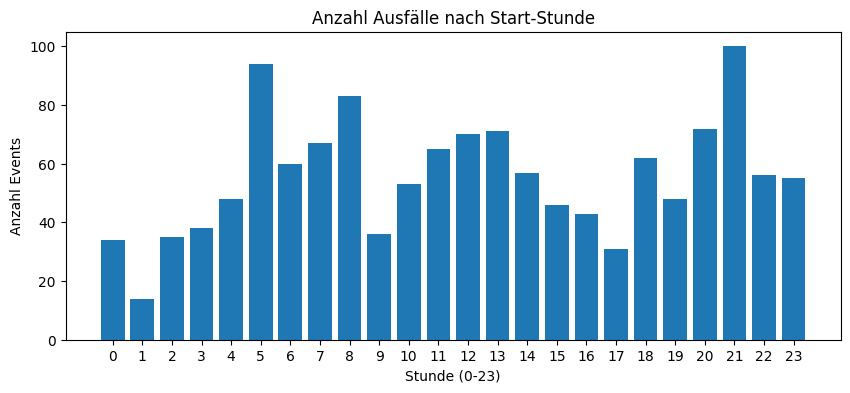

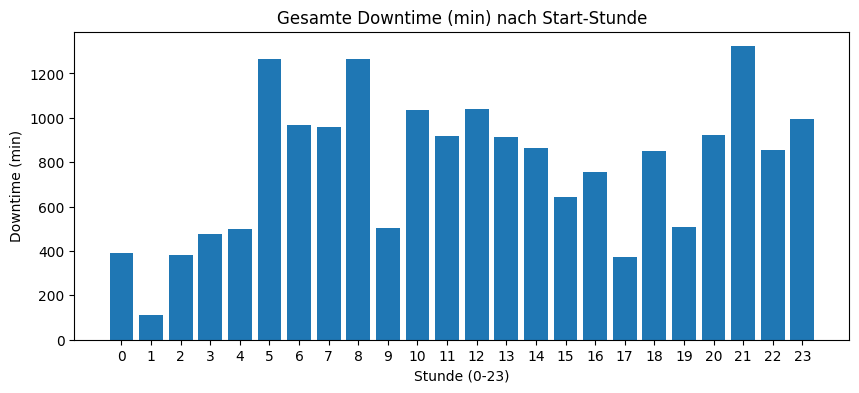

In [8]:
df_out["Start_hour"] = df_out["Start"].dt.hour
hour_stats = (df_out.dropna(subset=["Start_hour"])
              .groupby("Start_hour")
              .agg(events=("Downtime_min","size"),
                   downtime_min=("Downtime_min","sum"),
                   avg_downtime=("Downtime_min","mean"))
              .reset_index()
              .sort_values("Start_hour"))

display(hour_stats)

plt.figure(figsize=(10,4))
plt.bar(hour_stats["Start_hour"], hour_stats["events"])
plt.title("Anzahl Ausfälle nach Start-Stunde")
plt.xlabel("Stunde (0-23)")
plt.ylabel("Anzahl Events")
plt.xticks(range(0,24,1))
plt.show()

plt.figure(figsize=(10,4))
plt.bar(hour_stats["Start_hour"], hour_stats["downtime_min"])
plt.title("Gesamte Downtime (min) nach Start-Stunde")
plt.xlabel("Stunde (0-23)")
plt.ylabel("Downtime (min)")
plt.xticks(range(0,24,1))
plt.show()


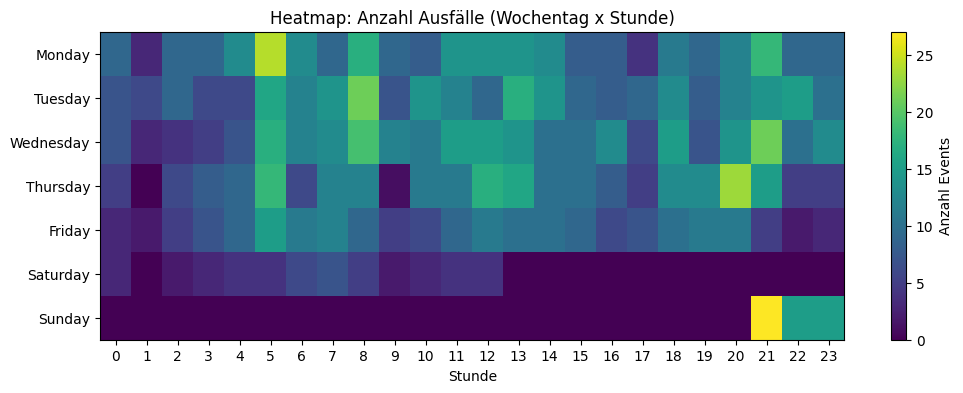

Start_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
DayName,,,,,,,,,,,,,,,,,,,,,,,,
Monday,9,3,9,9,13,24,13,9,17,9,8,14,14,14,13,8,8,4,11,9,12,18,9,9
Tuesday,7,6,9,6,6,16,12,14,21,7,14,12,9,17,14,9,8,9,13,8,12,14,15,10
Wednesday,7,3,4,5,7,17,12,13,19,12,11,15,15,14,10,10,13,6,15,7,14,21,10,13
Thursday,5,0,6,8,9,18,6,12,12,1,11,11,17,16,10,10,8,5,13,13,23,15,5,5
Friday,3,2,5,7,9,15,11,12,9,5,6,9,11,10,10,9,6,7,10,11,11,5,2,3
Saturday,3,0,2,3,4,4,6,7,5,2,3,4,4,0,0,0,0,0,0,0,0,0,0,0
Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,15,15


In [9]:
# Heatmap: Wochentag x Stunde (Event-Anzahl)
df_out["DayName"] = df_out["Datum"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

heat = (df_out.pivot_table(index="DayName", columns="Start_hour", values="Downtime_min",
                           aggfunc="size", fill_value=0)
        .reindex(order))

plt.figure(figsize=(12,4))
plt.imshow(heat.values, aspect="auto")
plt.title("Heatmap: Anzahl Ausfälle (Wochentag x Stunde)")
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(0,24,1), range(0,24,1))
plt.xlabel("Stunde")
plt.colorbar(label="Anzahl Events")
plt.show()

display(heat)


## 3) Welche Maschinen/Stationen haben die meisten Fehler?

,events,downtime_min,avg_downtime
Station_norm,,,
OP 10,129,1112.0,8.620155
R 05,112,1893.0,16.901786
R 06,106,1311.0,12.367925
R 07,78,879.0,11.269231
R.05,61,1121.0,18.377049
R.07,41,555.0,13.536585
OP 120.1,39,666.0,17.076923
OP 50,35,482.0,13.771429
OP 130.1,30,355.0,11.833333


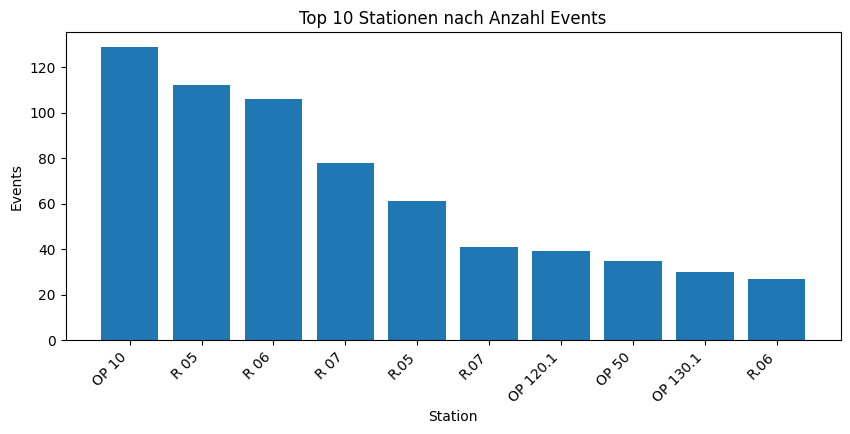

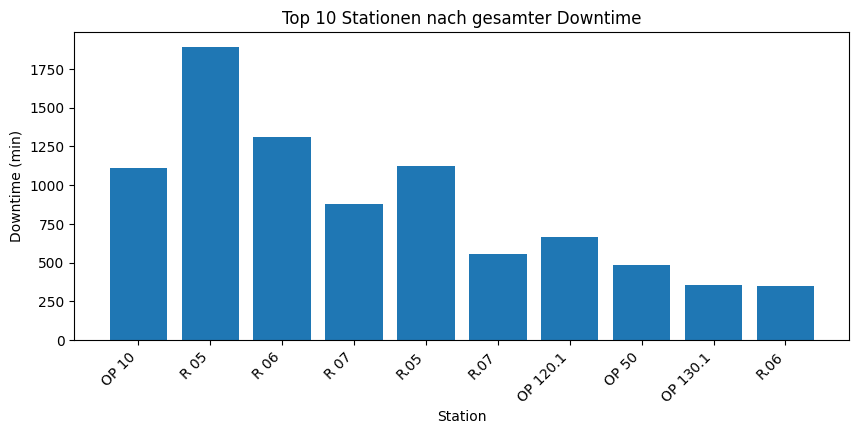

In [10]:
df_out["Station_norm"] = (df_out["Station/ OP"].astype("string")
                          .str.upper()
                          .str.replace(r"\s+", " ", regex=True)
                          .str.strip())

station_stats = (df_out.groupby("Station_norm")
                 .agg(events=("Downtime_min","size"),
                      downtime_min=("Downtime_min","sum"),
                      avg_downtime=("Downtime_min","mean"))
                 .sort_values(["events","downtime_min"], ascending=False))

display(station_stats.head(20))

top10 = station_stats.head(10).reset_index()

plt.figure(figsize=(10,4))
plt.bar(top10["Station_norm"], top10["events"])
plt.title("Top 10 Stationen nach Anzahl Events")
plt.xlabel("Station")
plt.ylabel("Events")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(top10["Station_norm"], top10["downtime_min"])
plt.title("Top 10 Stationen nach gesamter Downtime")
plt.xlabel("Station")
plt.ylabel("Downtime (min)")
plt.xticks(rotation=45, ha="right")
plt.show()


## 4) Welche Fehler/Ursachen wie oft? (Unterbrechungsursache)

,events,total_downtime,avg_downtime,median_downtime
Bemerkung,,,,
Wartungsplan,147,1581.0,10.755102,10.0
Vakuum nicht vorhanden,69,595.0,8.623188,8.0
Probleme mit Schweißdraht,27,214.0,7.925926,6.0
Trapezbleche einlagern/Sensoren ab-/anklemmen,26,202.0,7.769231,8.0
Schweißstörung am Fronius,22,152.0,6.909091,5.0
Trapezbleche einlagern,18,234.0,13.0,10.0
wöchentliche Reinigung,16,730.0,45.625,60.0
Trapezbleche einlagern-Sensoren ab-/anklemmen,16,120.0,7.5,8.0
Kollision,15,237.0,15.8,10.0


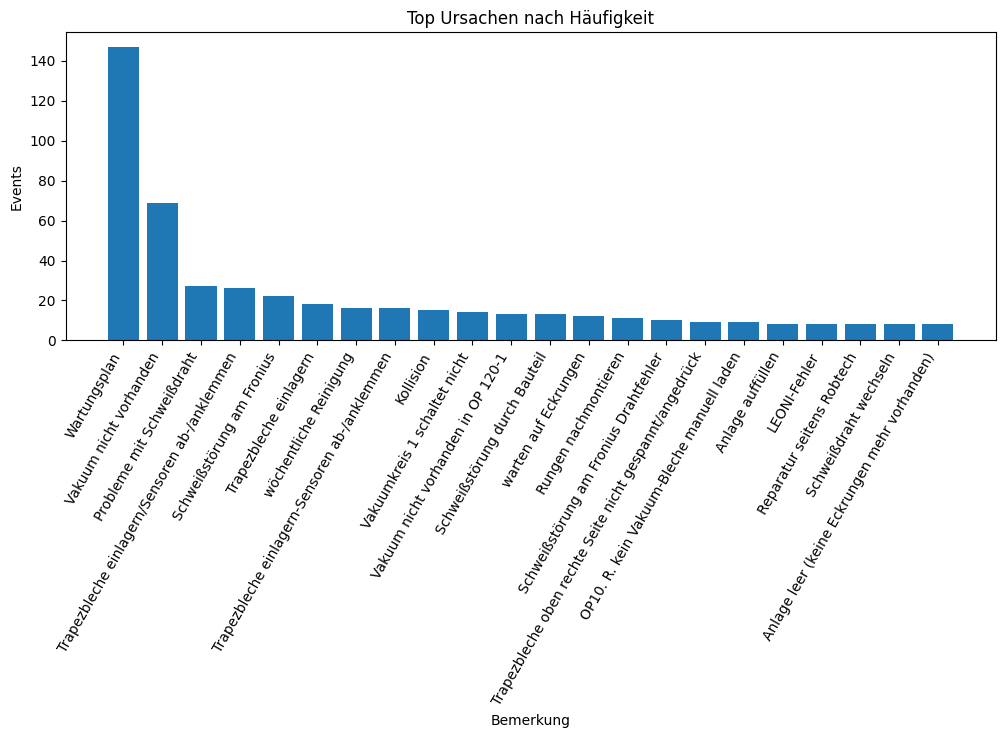

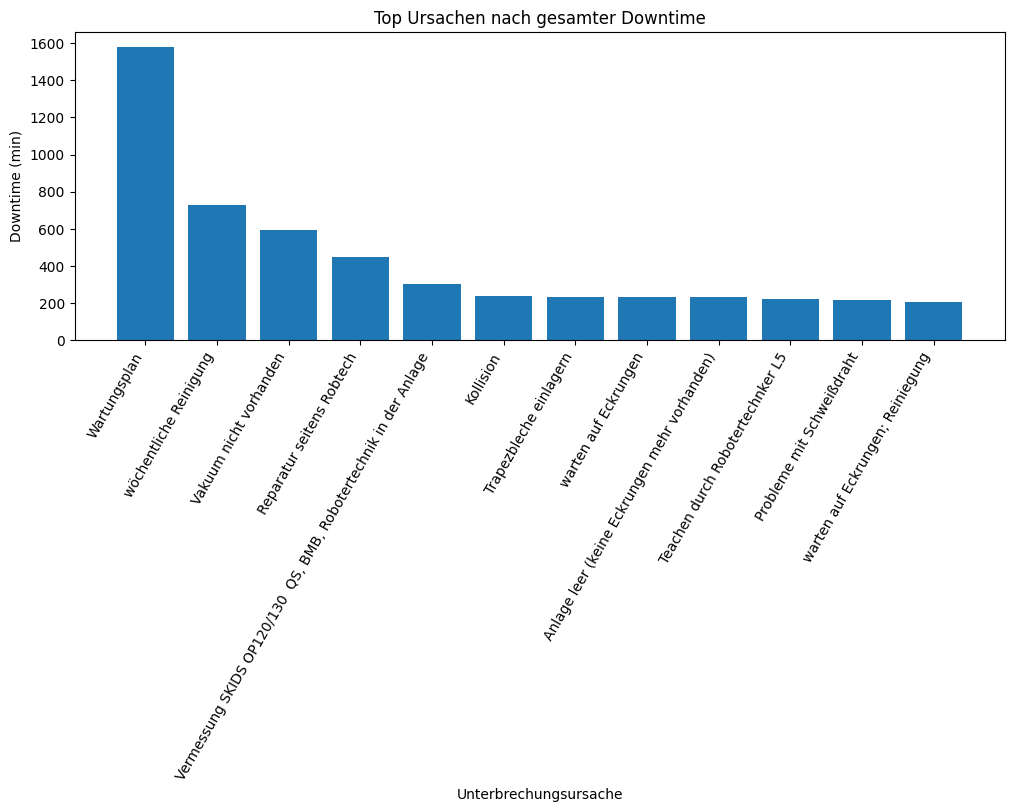

In [23]:
cause_stats = (df_out.groupby("Bemerkung")
               .agg(events=("Downtime_min","size"),
                    total_downtime=("Downtime_min","sum"),
                    avg_downtime=("Downtime_min","mean"),
                    median_downtime=("Downtime_min","median"))
               .sort_values("events", ascending=False))

display(cause_stats.head(20))

top_causes = cause_stats.head(22).reset_index()

plt.figure(figsize=(12,4))
plt.bar(top_causes["Bemerkung"].astype(str), top_causes["events"])
plt.title("Top Ursachen nach Häufigkeit")
plt.xlabel("Bemerkung")
plt.ylabel("Events")
plt.xticks(rotation=60, ha="right")
plt.show()

top_causes_downtime = cause_stats.sort_values("total_downtime", ascending=False).head(12).reset_index()

plt.figure(figsize=(12,4))
plt.bar(top_causes_downtime["Bemerkung"].astype(str), top_causes_downtime["total_downtime"])
plt.title("Top Ursachen nach gesamter Downtime")
plt.xlabel("Unterbrechungsursache")
plt.ylabel("Downtime (min)")
plt.xticks(rotation=60, ha="right")
plt.show()


## 5) Auffälligkeiten bei der Ausfalldauer (Kombinationen, Ausreißer)

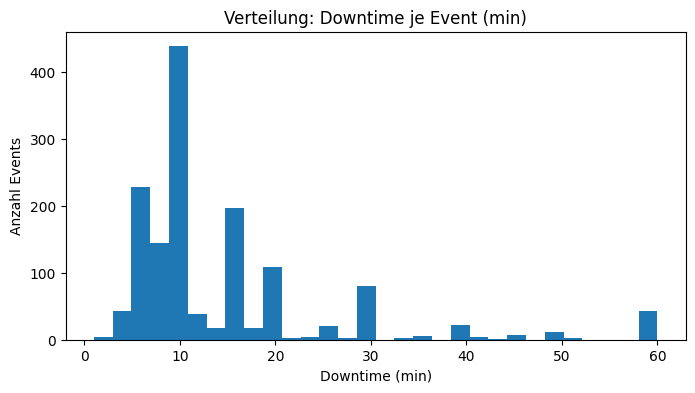

C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_42848\2828517972.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


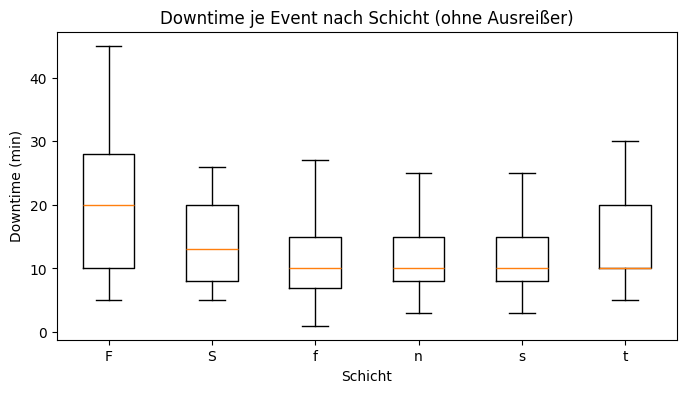

,Datum,Start,End,Schicht,Station_norm,Bemerkung,Downtime_min,Bemerkung
5422,2023-04-18,2023-04-18 10:00:00,2023-04-18 11:00:00,f,<NA>,wöchentliche Reinigung,60.0,wöchentliche Reinigung
4331,2023-03-15,2023-03-15 23:00:00,NaT,n,<NA>,wöchentliche Reinigung,60.0,wöchentliche Reinigung
4345,2023-03-16,NaT,NaT,n,<NA>,wöchentliche Reinigung,60.0,wöchentliche Reinigung
4334,2023-03-16,NaT,NaT,n,<NA>,wöchentliche Reinigung,60.0,wöchentliche Reinigung
4340,2023-03-16,NaT,NaT,n,<NA>,wöchentliche Reinigung,60.0,wöchentliche Reinigung
4342,2023-03-16,NaT,NaT,n,<NA>,wöchentliche Reinigung,60.0,wöchentliche Reinigung
3256,2023-02-27,2023-02-27 10:00:00,2023-02-27 11:00:00,f,FREITEXT,wöchentliche Reinigung,60.0,wöchentliche Reinigung
196,2023-01-06,2023-01-06 06:00:00,2023-01-06 07:00:00,f,<NA>,Keine QT. Oben L5 515136662 (Anlage Leer),60.0,Keine QT. Oben L5 515136662 (Anlage Leer)
3649,2023-03-04,2023-03-04 06:00:00,2023-03-04 07:00:00,f,<NA>,Kabelbruch/Störung in der Steuerung Instandset...,60.0,Kabelbruch/Störung in der Steuerung Instandset...
3700,2023-03-06,2023-03-06 05:00:00,2023-03-06 06:00:00,f,<NA>,Keine Gestelle,60.0,Keine Gestelle


In [24]:
# Verteilung der Downtime
plt.figure(figsize=(8,4))
plt.hist(df_out["Downtime_min"].dropna(), bins=30)
plt.title("Verteilung: Downtime je Event (min)")
plt.xlabel("Downtime (min)")
plt.ylabel("Anzahl Events")
plt.show()

# Downtime nach Schicht (Boxplot)
plt.figure(figsize=(8,4))
data = [df_out.loc[df_out["Schicht"]==s, "Downtime_min"].dropna() for s in sorted(df_out["Schicht"].dropna().unique())]
labels = [s for s in sorted(df_out["Schicht"].dropna().unique())]
plt.boxplot(data, labels=labels, showfliers=False)
plt.title("Downtime je Event nach Schicht (ohne Ausreißer)")
plt.xlabel("Schicht")
plt.ylabel("Downtime (min)")
plt.show()

# Ausreißer: Top 20 längste Events
top_long = (df_out.sort_values("Downtime_min", ascending=False)
            .loc[:, ["Datum","Start","End","Schicht","Station_norm","Bemerkung","Downtime_min","Bemerkung"]]
            .head(20))
display(top_long)


In [25]:
# Zusammenhang mit Output / Personal (wenn vorhanden)
num_cols = ["Downtime_min", "Dauer Arbeits-zeit", "Anzahl MA", "Menge N.i. O.", "Profi", "AHV", "Menge Gesamt (Stück)"]
corr = df_out[num_cols].corr(method="spearman", numeric_only=True)
display(corr)

# Scatter: Downtime vs Menge Gesamt
plt.figure(figsize=(6,4))
x = df_out["Menge Gesamt (Stück)"]
y = df_out["Downtime_min"]
plt.scatter(x, y, s=10)
plt.title("Downtime vs. Menge Gesamt (Stück)")
plt.xlabel("Menge Gesamt (Stück)")
plt.ylabel("Downtime (min)")
plt.show()

# Scatter: Downtime vs Anzahl MA
plt.figure(figsize=(6,4))
x = df_out["Anzahl MA"]
y = df_out["Downtime_min"]
plt.scatter(x, y, s=10)
plt.title("Downtime vs. Anzahl MA")
plt.xlabel("Anzahl MA")
plt.ylabel("Downtime (min)")
plt.show()

# Aggregation nach Anzahl MA
ma_stats = (df_out.groupby("Anzahl MA")
            .agg(events=("Downtime_min","size"),
                 avg_downtime=("Downtime_min","mean"),
                 total_downtime=("Downtime_min","sum"))
            .sort_index())
display(ma_stats)


KeyError: "['Profi', 'AHV'] not in index"

## 6) Ideen für nächste Schritte

- **Freitext reduzieren:** „Freitext“ ist sehr häufig – ideal wäre eine standardisierte Fehlerklassifikation (Dropdown).
- **Stationen konsolidieren:** z.B. `R 06` vs. `R06` (falls vorhanden) vereinheitlichen.
- **Ausfälle nach Priorität:** Fokus auf Kombination aus **hoher Downtime** + **hoher Häufigkeit** (Pareto).
- **Geplante vs. ungeplante Stops:** Ursachen wie „Wartungsplan“/„Reinigung“ ggf. separat betrachten.


## 7) Zusammenhänge: Schicht × Zeit × MA × Downtime × Ursache

Die folgenden Blöcke zeigen dir die wichtigsten Kombinationen aus **Schicht**, **Uhrzeit**, **Anzahl MA**, **Ausfalldauer** und **Ursache** – als Tabellen und Visualisierungen.

> Tipp: Wenn du sehr viele Ursachen hast, nutze die *Top-N*-Filter in den Zellen, damit die Plots lesbar bleiben.


In [30]:
# --- Feature Engineering für Zusammenhangsanalysen ---
df = df_clean.copy()

# Robustheit / Standardisierung
df["Ursache"] = df.get("Unterbrechungsursache", pd.Series(index=df.index)).fillna("Unbekannt").astype(str).str.strip()
df["Station"] = df.get("Station/ OP", pd.Series(index=df.index)).fillna("Unbekannt").astype(str).str.strip()

# Schicht-Label (Codes aus deinen Daten: f/s/n/t)
shift_map = {"f": "Früh", "s": "Spät", "n": "Nacht", "t": "Tag"}
df["Schicht_label"] = df.get("Schicht", pd.Series(index=df.index)).map(shift_map)
df["Schicht_label"] = df["Schicht_label"].fillna(df.get("Schicht", pd.Series(index=df.index)).fillna("Unbekannt").astype(str))

# Zeit-Features
df["Start_ts"] = pd.to_datetime(df.get("Start", pd.Series(index=df.index)), errors="coerce")
df["Start_date"] = df["Start_ts"].dt.date
df["Start_hour"] = df["Start_ts"].dt.hour

weekday_de = {0:"Mo", 1:"Di", 2:"Mi", 3:"Do", 4:"Fr", 5:"Sa", 6:"So"}
df["Wochentag_de"] = df["Start_ts"].dt.dayofweek.map(weekday_de)

# Anzahl MA (numerisch) + Bins
df["MA"] = pd.to_numeric(df.get("Anzahl MA", pd.Series(index=df.index)), errors="coerce")
df["MA_bin"] = pd.cut(
    df["MA"],
    bins=[-0.1, 2, 3, 4, 5, 6, 99],
    labels=["<=2", "3", "4", "5", "6", ">=7"]
)

# Downtime (numerisch) + Bins
df["Downtime_min"] = pd.to_numeric(df.get("Downtime_min", pd.Series(index=df.index)), errors="coerce")
df["Downtime_bin"] = pd.cut(
    df["Downtime_min"],
    bins=[-0.1, 0, 5, 15, 30, 60, 999999],
    labels=["0", "1-5", "6-15", "16-30", "31-60", ">60"]
)

# Time-Blocks (optional)
df["Tagesblock"] = pd.cut(
    df["Start_hour"],
    bins=[-0.1, 5, 11, 17, 23],
    labels=["Nacht(0-5)", "Vormittag(6-11)", "Nachmittag(12-17)", "Abend(18-23)"]
)

# Quick-Checks
print("Zeilen:", len(df))
print("Schichten:", df["Schicht_label"].value_counts(dropna=False).to_dict())
print("Top Ursachen:", df["Ursache"].value_counts().head(10).to_dict())


Zeilen: 7763
Schichten: {'Früh': 3966, 'Nacht': 1887, 'Spät': 1591, 'S': 162, 'F': 105, 'Tag': 51, 'Unbekannt': 1}
Top Ursachen: {'Unbekannt': 7763}


In [28]:
# --- Hilfsfunktionen (Heatmap + Top-Kombinationen) ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_heatmap(pivot: pd.DataFrame, title: str, xlabel: str = "", ylabel: str = "", annotate: bool = False):
    # pivot: index=y, columns=x, values=z (numeric)
    if pivot.empty:
        print("Pivot ist leer – nichts zu plotten.")
        return

    data = pivot.values.astype(float)
    fig, ax = plt.subplots(figsize=(max(8, 0.45*len(pivot.columns)), max(3, 0.45*len(pivot.index))))
    im = ax.imshow(data, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=90)
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if annotate and data.size <= 600:  # nur kleine Heatmaps annotieren
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                v = data[i, j]
                if np.isfinite(v):
                    ax.text(j, i, f"{v:.0f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

def top_combos(df_in: pd.DataFrame, group_cols, n=20, sort_by="downtime_sum"):
    g = (df_in
         .groupby(group_cols, dropna=False)
         .agg(events=("Downtime_min", "size"),
              downtime_sum=("Downtime_min", "sum"),
              downtime_avg=("Downtime_min", "mean"),
              downtime_median=("Downtime_min", "median"))
         .reset_index()
        )
    return g.sort_values(sort_by, ascending=False).head(n)


### 7.1 Schicht × Uhrzeit (Stoßzeiten je Schicht)

- **Heatmap Events** zeigt, wann in welcher Schicht die meisten Ereignisse starten.
- **Heatmap Downtime-Summe** zeigt, wann die teuersten Zeitfenster sind.


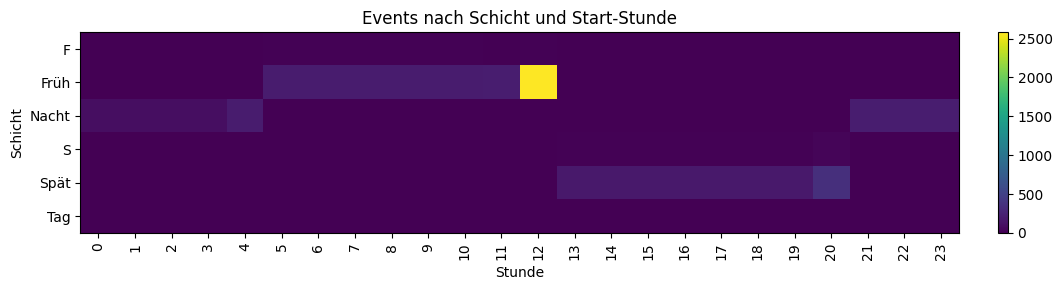

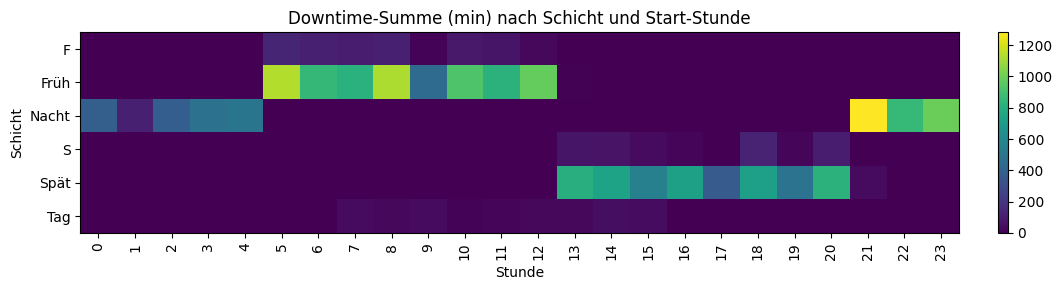

Start_hour,3,4,5,6,7,8,9,10,11,12,14,15,16,18,19,20,21,22,23
Schicht_label,,,,,,,,,,,,,,,,,,,
F,NaN,NaN,15.0,15.0,12.0,NaN,12.0,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Früh,NaN,NaN,198.0,198.0,NaN,197.0,NaN,NaN,205.0,2580.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nacht,99.0,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,210.0,210.0
S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,18.0,18.0,36.0,NaN,NaN,NaN
Spät,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.0,177.0,NaN,177.0,177.0,350.0,NaN,NaN,NaN
Tag,NaN,NaN,NaN,NaN,6.0,NaN,6.0,6.0,NaN,9.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# --- Schicht × Stunde: Events & Downtime ---
pivot_events = pd.pivot_table(
    df, index="Schicht_label", columns="Start_hour",
    values="Downtime_min", aggfunc="size", fill_value=0
).reindex(columns=list(range(24)), fill_value=0)

pivot_downtime = pd.pivot_table(
    df, index="Schicht_label", columns="Start_hour",
    values="Downtime_min", aggfunc="sum", fill_value=0
).reindex(columns=list(range(24)), fill_value=0)

plot_heatmap(pivot_events, "Events nach Schicht und Start-Stunde", xlabel="Stunde", ylabel="Schicht", annotate=False)
plot_heatmap(pivot_downtime, "Downtime-Summe (min) nach Schicht und Start-Stunde", xlabel="Stunde", ylabel="Schicht", annotate=False)

# Top-Stunden je Schicht (nach Events)
pivot_events.apply(lambda s: s.sort_values(ascending=False).head(5), axis=1)


### 7.2 Ursache × Schicht (welche Ursachen dominieren in welcher Schicht?)

- **Top-N Ursachen** filtern, damit die Darstellung übersichtlich bleibt.
- Tabellen zeigen **Events**, **Downtime-Summe** und **Ø-Downtime**.


In [ ]:
# --- Ursache × Schicht (Top-N) ---
TOP_N = 12  # anpassen
top_causes = df["Ursache"].value_counts().head(TOP_N).index
df_top = df[df["Ursache"].isin(top_causes)].copy()

tbl_shift_cause = (df_top
    .groupby(["Schicht_label", "Ursache"], dropna=False)
    .agg(events=("Downtime_min","size"),
         downtime_sum=("Downtime_min","sum"),
         downtime_avg=("Downtime_min","mean"))
    .reset_index()
    .sort_values(["Schicht_label","events"], ascending=[True,False])
)
display(tbl_shift_cause)

pivot_sc_events = tbl_shift_cause.pivot(index="Schicht_label", columns="Ursache", values="events").fillna(0)
pivot_sc_sum   = tbl_shift_cause.pivot(index="Schicht_label", columns="Ursache", values="downtime_sum").fillna(0)
pivot_sc_avg   = tbl_shift_cause.pivot(index="Schicht_label", columns="Ursache", values="downtime_avg").fillna(0)

plot_heatmap(pivot_sc_events, f"Events: Schicht × Ursache (Top {TOP_N})", xlabel="Ursache", ylabel="Schicht", annotate=False)
plot_heatmap(pivot_sc_sum,   f"Downtime-Summe: Schicht × Ursache (Top {TOP_N})", xlabel="Ursache", ylabel="Schicht", annotate=False)
plot_heatmap(pivot_sc_avg,   f"Ø Downtime: Schicht × Ursache (Top {TOP_N})", xlabel="Ursache", ylabel="Schicht", annotate=False)


### 7.3 Ursache × Uhrzeit (wann tritt welche Ursache auf?)

Hier siehst du, ob bestimmte Ursachen **zu bestimmten Uhrzeiten** gehäuft auftreten.


In [ ]:
# --- Ursache × Stunde (Top-N nach Häufigkeit) ---
TOP_N = 12  # anpassen
top_causes = df["Ursache"].value_counts().head(TOP_N).index
df_top = df[df["Ursache"].isin(top_causes)].copy()

pivot_cause_hour_cnt = pd.pivot_table(
    df_top, index="Ursache", columns="Start_hour",
    values="Downtime_min", aggfunc="size", fill_value=0
).reindex(columns=list(range(24)), fill_value=0)

pivot_cause_hour_avg = pd.pivot_table(
    df_top, index="Ursache", columns="Start_hour",
    values="Downtime_min", aggfunc="mean", fill_value=0
).reindex(columns=list(range(24)), fill_value=np.nan)

plot_heatmap(pivot_cause_hour_cnt, f"Events: Ursache × Start-Stunde (Top {TOP_N})", xlabel="Stunde", ylabel="Ursache", annotate=False)
plot_heatmap(pivot_cause_hour_avg, f"Ø Downtime: Ursache × Start-Stunde (Top {TOP_N})", xlabel="Stunde", ylabel="Ursache", annotate=False)


### 7.4 Anzahl MA × Downtime (und Interaktion mit Schicht/Ursache)

Diese Blöcke zeigen:
- ob mehr/weniger Personal mit **längerer/kürzerer Downtime** zusammenhängt,
- ob der Zusammenhang **je Schicht** oder **je Ursache** unterschiedlich ist.


In [ ]:
# --- MA × Downtime: Überblick ---
tmp = df.dropna(subset=["MA", "Downtime_min"]).copy()

# Korrelationen (robust: Spearman)
spearman = tmp[["MA","Downtime_min"]].corr(method="spearman").iloc[0,1]
pearson  = tmp[["MA","Downtime_min"]].corr(method="pearson").iloc[0,1]
print("Korrelation MA ↔ Downtime (Spearman):", round(float(spearman), 3))
print("Korrelation MA ↔ Downtime (Pearson): ", round(float(pearson), 3))

# Scatter (MA vs Downtime)
plt.figure(figsize=(9,5))
plt.scatter(tmp["MA"], tmp["Downtime_min"], alpha=0.25)
plt.title("Scatter: Anzahl MA vs Downtime (min)")
plt.xlabel("Anzahl MA")
plt.ylabel("Downtime (min)")
plt.tight_layout()
plt.show()

# Gruppiert: Schicht × MA (Events / Ø / Summe)
tbl_shift_ma = (tmp
    .groupby(["Schicht_label","MA"], dropna=False)
    .agg(events=("Downtime_min","size"),
         downtime_sum=("Downtime_min","sum"),
         downtime_avg=("Downtime_min","mean"))
    .reset_index()
    .sort_values(["Schicht_label","MA"])
)
display(tbl_shift_ma)

# Plot: Ø Downtime je MA und Schicht
for sh in sorted(tbl_shift_ma["Schicht_label"].dropna().unique()):
    sub = tbl_shift_ma[tbl_shift_ma["Schicht_label"]==sh]
    plt.figure(figsize=(8,4))
    plt.plot(sub["MA"], sub["downtime_avg"], marker="o")
    plt.title(f"Ø Downtime je Anzahl MA – Schicht: {sh}")
    plt.xlabel("Anzahl MA")
    plt.ylabel("Ø Downtime (min)")
    plt.tight_layout()
    plt.show()


In [ ]:
# --- MA × Downtime × Ursache (Top-N Ursachen) ---
TOP_N = 10
top_causes = df["Ursache"].value_counts().head(TOP_N).index
tmp = df[df["Ursache"].isin(top_causes)].dropna(subset=["MA","Downtime_min"]).copy()

tbl_cause_ma = (tmp
    .groupby(["Ursache","MA"], dropna=False)
    .agg(events=("Downtime_min","size"),
         downtime_sum=("Downtime_min","sum"),
         downtime_avg=("Downtime_min","mean"))
    .reset_index()
    .sort_values(["Ursache","MA"])
)
display(tbl_cause_ma)

pivot = tbl_cause_ma.pivot(index="Ursache", columns="MA", values="downtime_avg").fillna(0)
plot_heatmap(pivot, f"Ø Downtime: Ursache × Anzahl MA (Top {TOP_N})", xlabel="Anzahl MA", ylabel="Ursache", annotate=False)


### 7.5 Dreifach-Kombinationen (Schicht × Station × Ursache)

Damit findest du die **teuersten** und **häufigsten** Problemkombinationen.


In [ ]:
# --- Top Kombinationen nach Downtime-Summe ---
top_by_sum = top_combos(df, ["Schicht_label", "Station", "Ursache"], n=25, sort_by="downtime_sum")
display(top_by_sum)

# --- Top Kombinationen nach Häufigkeit (Events) ---
top_by_events = top_combos(df, ["Schicht_label", "Station", "Ursache"], n=25, sort_by="events")
display(top_by_events)

# Optional: nur ungeplante Ursachen (simple Heuristik – anpassen!)
planned_patterns = r"(wartung|reinigung|geplant|plan|service)"
df_unplanned = df[~df["Ursache"].str.contains(planned_patterns, case=False, na=False)].copy()

top_unplanned_sum = top_combos(df_unplanned, ["Schicht_label","Station","Ursache"], n=25, sort_by="downtime_sum")
display(top_unplanned_sum)


### 7.6 Auffällige lange Ausfälle: wer/wann/warum?

- Zeigt die **Top-Langläufer** und deren Kombinationen.
- Hilft, Ausreißer zu verstehen (z.B. 60-min-Blockungen, Wiederholungen, Sonderfälle).


In [ ]:
# --- Long-Stop Outlier Analyse ---
q95 = df["Downtime_min"].quantile(0.95)
q99 = df["Downtime_min"].quantile(0.99)
print("P95 Downtime:", q95, "min")
print("P99 Downtime:", q99, "min")

long_df = df[df["Downtime_min"] >= q95].copy()
print("Anzahl Events >= P95:", len(long_df))

top_long = long_df.sort_values("Downtime_min", ascending=False).head(30)[
    ["Start_ts","Schicht_label","Start_hour","MA","Station","Ursache","Downtime_min","Bemerkung"]
]
display(top_long)

display(long_df["Schicht_label"].value_counts())
display(long_df["Ursache"].value_counts().head(15))
display(top_combos(long_df, ["Schicht_label","Station","Ursache"], n=20, sort_by="events"))


### 7.7 Zusammenhangsstärke zwischen Kategorien (Chi² / Cramér's V)

Cramér's V gibt grob an, wie stark zwei kategoriale Variablen zusammenhängen (0 = kein Zusammenhang, 1 = sehr stark).


In [ ]:
# --- Cramér's V (kategoriale Zusammenhänge) ---
def cramers_v(confusion_matrix: pd.DataFrame) -> float:
    obs = confusion_matrix.values.astype(float)
    if obs.size == 0:
        return np.nan
    n = obs.sum()
    if n == 0:
        return np.nan
    row_sums = obs.sum(axis=1, keepdims=True)
    col_sums = obs.sum(axis=0, keepdims=True)
    expected = row_sums @ col_sums / n
    mask = expected > 0
    chi2 = ((obs[mask] - expected[mask])**2 / expected[mask]).sum()
    r, k = obs.shape
    phi2 = chi2 / n
    denom = max(1e-9, min(k-1, r-1))
    return float(np.sqrt(phi2 / denom))

def show_cramers_v(var_a: str, var_b: str, top_b=None):
    d = df[[var_a, var_b]].dropna().copy()
    if top_b is not None:
        top_vals = d[var_b].value_counts().head(top_b).index
        d = d[d[var_b].isin(top_vals)]
    cm = pd.crosstab(d[var_a], d[var_b])
    v = cramers_v(cm)
    print(f"Cramér's V({var_a} vs {var_b}) =", round(v, 3), "| shape:", cm.shape)
    display(cm.head(20))

show_cramers_v("Schicht_label", "Ursache", top_b=12)
show_cramers_v("Tagesblock", "Ursache", top_b=12)
show_cramers_v("Schicht_label", "MA_bin")


### Bonus: Mini-Modell (optional) – welche Faktoren erklären Downtime am stärksten?

Das ist kein „fertiges“ Predictive-Model, aber hilfreich, um schnell zu sehen, ob z.B. **Ursache** oder **Station** sehr dominant ist.


In [ ]:
# --- Optional: RandomForest zur Feature-Importance (wenn sklearn installiert ist) ---
try:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_absolute_error, r2_score

    model_df = df.dropna(subset=["Downtime_min","Start_hour"]).copy()
    model_df = model_df[model_df["Downtime_min"] >= 0]

    feature_cols_cat = ["Schicht_label","Station","Ursache","Tagesblock","Wochentag_de"]
    feature_cols_num = ["Start_hour","MA"]

    X = model_df[feature_cols_cat + feature_cols_num].copy()
    y = model_df["Downtime_min"].astype(float)

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
            ("num", "passthrough", feature_cols_num),
        ]
    )

    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=3
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    pipe = Pipeline(steps=[("pre", pre), ("rf", rf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    print("MAE:", round(mean_absolute_error(y_test, pred), 2), "min")
    print("R²:", round(r2_score(y_test, pred), 3))

    ohe = pipe.named_steps["pre"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(feature_cols_cat)
    feature_names = np.concatenate([cat_names, np.array(feature_cols_num, dtype=object)])

    importances = pipe.named_steps["rf"].feature_importances_
    imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(25)
    display(imp)

except Exception as e:
    print("sklearn nicht verfügbar oder Fehler beim Modelllauf:", repr(e))


In [ ]:
###Setup + Spalten robust finden + Standard-Features bauen

In [ ]:


# -------------------------
# Helpers
# -------------------------
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in out.columns]
    return out

def find_col(df: pd.DataFrame, patterns, required=False, prefer_contains=True):
    """
    patterns: list[str|regex]
    returns first matching column or None
    """
    cols = list(df.columns)
    for pat in patterns:
        rx = re.compile(pat, re.IGNORECASE) if isinstance(pat, str) else pat
        # 1) exact-ish match
        for c in cols:
            if rx.fullmatch(str(c).strip()):
                return c
        # 2) contains match
        if prefer_contains:
            for c in cols:
                if rx.search(str(c)):
                    return c
    if required:
        raise KeyError(f"Keine passende Spalte gefunden für patterns={patterns}")
    return None

def to_datetime_safe(s: pd.Series):
    return pd.to_datetime(s, errors="coerce", dayfirst=True, utc=False)

def to_num_safe(s: pd.Series):
    return pd.to_numeric(s, errors="coerce")

def duration_cols(df: pd.DataFrame):
    # alle Spalten die "Dauer" enthalten (typisch: mehrere Komponenten)
    return [c for c in df.columns if re.search(r"\bDauer\b", str(c), re.IGNORECASE)]

def make_heatmap(pivot: pd.DataFrame, title: str, xlabel: str, ylabel: str):
    fig, ax = plt.subplots(figsize=(10, 4))
    data = pivot.values
    im = ax.imshow(data, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.astype(str), rotation=45, ha="right")
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.astype(str))
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# -------------------------
# Load df
# -------------------------
df = df_clean.copy()  # <- ggf. anpassen
df = norm_cols(df)

# -------------------------
# Try detect key columns
# -------------------------
COL_TS_START = find_col(df, [r"^Start(zeit|zeitpunkt)$", r"^Beginn$", r"^Start$", r"Start", r"Beginn"], required=False)
COL_TS_END   = find_col(df, [r"^End(e|zeit|zeitpunkt)$", r"^Ende$", r"Ende", r"End"], required=False)
COL_SHIFT    = find_col(df, [r"^Schicht$", r"Schicht"], required=False)
COL_STATION  = find_col(df, [r"^Station(/ OP)?$", r"^Arbeitsplatz$", r"Station", r"Arbeitsplatz", r"OP"], required=False)
COL_CAUSE    = find_col(df, [r"^Unterbrechungsursache$", r"Ursache", r"Stör(grund|ursache)"], required=False)
COL_MA       = find_col(df, [r"^Anzahl\s*MA$", r"MA", r"Mitarbeiter"], required=False)
COL_QTY      = find_col(df, [r"^Menge\s*Gesamt$", r"Menge", r"Stück"], required=False)
COL_COMMENT  = find_col(df, [r"^Bemerkung$", r"Kommentar", r"Freitext", r"Notiz"], required=False)

# -------------------------
# Standard columns build
# -------------------------
if COL_TS_START:
    df["_ts_start"] = to_datetime_safe(df[COL_TS_START])
else:
    df["_ts_start"] = pd.NaT

if COL_TS_END:
    df["_ts_end"] = to_datetime_safe(df[COL_TS_END])
else:
    df["_ts_end"] = pd.NaT

# Downtime total (Summe aller Dauer-* Spalten)
dcols = duration_cols(df)
for c in dcols:
    df[c] = to_num_safe(df[c])

if dcols:
    df["_downtime_total_min"] = df[dcols].sum(axis=1, min_count=1)
else:
    # fallback: suche nach irgendeiner Gesamtdauer
    COL_DUR = find_col(df, [r"^Dauer$", r"Gesamt.*Dauer", r"Downtime"], required=False)
    df["_downtime_total_min"] = to_num_safe(df[COL_DUR]) if COL_DUR else np.nan

# Station / Ursache / Schicht / MA / Menge
df["_station"] = df[COL_STATION].astype(str).str.strip() if COL_STATION else "UNKNOWN"
df["_cause"]   = df[COL_CAUSE].astype(str).str.strip() if COL_CAUSE else "UNKNOWN"
df["_shift"]   = df[COL_SHIFT].astype(str).str.strip() if COL_SHIFT else "UNKNOWN"
df["_ma"]      = to_num_safe(df[COL_MA]) if COL_MA else np.nan
df["_qty"]     = to_num_safe(df[COL_QTY]) if COL_QTY else np.nan

# Zeitfeatures
df["_date"]    = df["_ts_start"].dt.date
df["_hour"]    = df["_ts_start"].dt.hour
df["_weekday"] = df["_ts_start"].dt.day_name()
df["_week"]    = df["_ts_start"].dt.isocalendar().week.astype("Int64")
df["_month"]   = df["_ts_start"].dt.to_period("M").astype(str)

# Filter: echte Events (optional)
df_evt = df.loc[df["_downtime_total_min"].fillna(0) > 0].copy()

print("Detected columns:",
      {"ts_start": COL_TS_START, "ts_end": COL_TS_END, "shift": COL_SHIFT, "station": COL_STATION,
       "cause": COL_CAUSE, "ma": COL_MA, "qty": COL_QTY, "comment": COL_COMMENT})
print("Rows (events):", len(df_evt), " / total:", len(df))

In [ ]:
### Reliability KPIs: MTBF / MTTR je Station (und je Ursache)

In [ ]:
# MTTR: Ø Downtime
mttr_station = (
    df_evt.groupby("_station")["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", mttr_mean="mean", mttr_median="median")
    .sort_values(["downtime_sum", "events"], ascending=False)
)
display(mttr_station.head(20))

# MTBF je Station (Zeit zwischen Starts, in Minuten)
df_mtbf = df_evt.dropna(subset=["_ts_start"]).sort_values(["_station", "_ts_start"]).copy()
df_mtbf["_dt_prev_min"] = df_mtbf.groupby("_station")["_ts_start"].diff().dt.total_seconds() / 60.0

mtbf_station = (
    df_mtbf.groupby("_station")["_dt_prev_min"]
    .agg(mtbf_mean="mean", mtbf_median="median", mtbf_p10=lambda s: np.nanpercentile(s, 10), mtbf_p90=lambda s: np.nanpercentile(s, 90))
    .sort_values("mtbf_mean", ascending=False)
)
display(mtbf_station.head(20))

# Optional: MTTR/MTBF je Ursache
mttr_cause = (
    df_evt.groupby("_cause")["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", mttr_mean="mean", mttr_median="median")
    .sort_values(["downtime_sum", "events"], ascending=False)
)
display(mttr_cause.head(20))

In [ ]:
### Zeitmuster: Wochentag×Stunde + Trends + Rolling

In [ ]:
# Heatmap: Events (weekday x hour)
pivot_cnt = pd.pivot_table(df_evt, index="_weekday", columns="_hour", values="_downtime_total_min", aggfunc="count", fill_value=0)

# Ordnung Wochentage
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot_cnt = pivot_cnt.reindex([d for d in weekday_order if d in pivot_cnt.index])

make_heatmap(pivot_cnt, "Events nach Wochentag × Stunde", "Stunde", "Wochentag")

# Heatmap: Downtime Summe
pivot_sum = pd.pivot_table(df_evt, index="_weekday", columns="_hour", values="_downtime_total_min", aggfunc="sum", fill_value=0)
pivot_sum = pivot_sum.reindex(pivot_cnt.index)
make_heatmap(pivot_sum, "Downtime-Summe (min) nach Wochentag × Stunde", "Stunde", "Wochentag")

# Daily trend + rolling mean
daily = (
    df_evt.dropna(subset=["_ts_start"])
    .set_index("_ts_start")
    .resample("D")
    .agg(events=("_downtime_total_min","count"), downtime_sum=("_downtime_total_min","sum"), downtime_mean=("_downtime_total_min","mean"))
)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily.index, daily["events"])
ax.plot(daily.index, daily["events"].rolling(7, min_periods=3).mean())
ax.set_title("Events pro Tag (inkl. 7-Tage Rolling Mean)")
ax.set_xlabel("Datum")
ax.set_ylabel("Events")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily.index, daily["downtime_sum"])
ax.plot(daily.index, daily["downtime_sum"].rolling(7, min_periods=3).mean())
ax.set_title("Downtime-Summe pro Tag (min) (inkl. 7-Tage Rolling Mean)")
ax.set_xlabel("Datum")
ax.set_ylabel("Downtime (min)")
plt.tight_layout()
plt.show()

In [ ]:
### Burst-/Cluster-Erkennung: „Viele Stops in kurzer Zeit“ pro Station

In [ ]:
# Für jede Station: Anzahl Events innerhalb der letzten 60 Minuten (rolling)
df_burst = df_evt.dropna(subset=["_ts_start"]).sort_values("_ts_start").copy()
df_burst = df_burst.set_index("_ts_start")

# Rolling count pro Station
burst_60 = (
    df_burst.groupby("_station")["_downtime_total_min"]
    .rolling("60min")
    .count()
    .rename("events_last_60min")
    .reset_index()
)

df_burst = df_burst.reset_index().merge(burst_60, on=["_station","_ts_start"], how="left")

# Top Bursts
top_bursts = df_burst.sort_values("events_last_60min", ascending=False)[["_ts_start","_station","_cause","_downtime_total_min","events_last_60min"]].head(30)
display(top_bursts)

# Verteilung: Wie oft kommen >=3 Events/60min vor?
print("Anteil Events mit >=3 Events in 60min Fenster:", (df_burst["events_last_60min"]>=3).mean())

In [ ]:
### Interaktionen: Station×Ursache×Schicht + „Lift“ (überproportional)

In [ ]:
# Top Kombos nach Downtime-Summe / Events
combo2 = (
    df_evt.groupby(["_station","_cause"])["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", downtime_mean="mean")
    .sort_values(["downtime_sum","events"], ascending=False)
)
display(combo2.head(30))

combo3 = (
    df_evt.groupby(["_shift","_station","_cause"])["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", downtime_mean="mean")
    .sort_values(["downtime_sum","events"], ascending=False)
)
display(combo3.head(30))

# Lift: P(cause | shift) / P(cause)
base = df_evt["_cause"].value_counts(normalize=True)
by_shift = (
    df_evt.groupby("_shift")["_cause"]
    .value_counts(normalize=True)
    .rename("p_cause_given_shift")
    .reset_index()
)
by_shift["p_cause"] = by_shift["_cause"].map(base)
by_shift["lift"] = by_shift["p_cause_given_shift"] / by_shift["p_cause"]

# Top overrepresented Ursachen je Schicht (mindestens 30 Events zur Stabilität)
counts = df_evt.groupby(["_shift","_cause"]).size().rename("n").reset_index()
lift = by_shift.merge(counts, on=["_shift","_cause"], how="left")
lift = lift[lift["n"] >= 30].sort_values(["_shift","lift"], ascending=[True, False])

display(lift.groupby("_shift").head(10))

In [ ]:
### Severity-Klassen (Dauerklassen) + Kombos

In [ ]:
# Severity Bins
bins = [-np.inf, 5, 15, 30, 60, np.inf]
labels = ["<5", "5-15", "15-30", "30-60", ">60"]
df_sev = df_evt.copy()
df_sev["_severity"] = pd.cut(df_sev["_downtime_total_min"], bins=bins, labels=labels)

# Ursache × Severity (Counts)
pv = pd.pivot_table(df_sev, index="_cause", columns="_severity", values="_downtime_total_min", aggfunc="count", fill_value=0)
pv["total"] = pv.sum(axis=1)
pv = pv.sort_values("total", ascending=False)
display(pv.head(20))

# Station × Severity (Counts)
pv2 = pd.pivot_table(df_sev, index="_station", columns="_severity", values="_downtime_total_min", aggfunc="count", fill_value=0)
pv2["total"] = pv2.sum(axis=1)
pv2 = pv2.sort_values("total", ascending=False)
display(pv2.head(20))

# Schicht × Severity (Share)
pv3 = pd.pivot_table(df_sev, index="_shift", columns="_severity", values="_downtime_total_min", aggfunc="count", fill_value=0)
pv3_share = pv3.div(pv3.sum(axis=1), axis=0)
display(pv3_share)

In [ ]:
### Ausreißer-Analyse (Top-Langstopps + Vergleich „Outlier vs Normal“)

In [ ]:
# Schwellen: P95 / P99
p95 = df_evt["_downtime_total_min"].quantile(0.95)
p99 = df_evt["_downtime_total_min"].quantile(0.99)
print("P95:", p95, "P99:", p99)

df_out = df_evt.copy()
df_out["_is_outlier_p95"] = df_out["_downtime_total_min"] >= p95

# Top 50 längste
top_long = df_out.sort_values("_downtime_total_min", ascending=False).head(50)[
    ["_ts_start","_shift","_station","_cause","_ma","_qty","_downtime_total_min"]
]
display(top_long)

# Vergleich Outlier vs Normal
cmp = (
    df_out.groupby("_is_outlier_p95")
    .agg(
        n=("_downtime_total_min","size"),
        downtime_mean=("_downtime_total_min","mean"),
        ma_mean=("_ma","mean"),
        qty_mean=("_qty","mean"),
    )
)
display(cmp)

# Welche Ursachen/Stationen dominieren bei Outliers?
out_cause = df_out[df_out["_is_outlier_p95"]]["_cause"].value_counts().head(20)
out_station = df_out[df_out["_is_outlier_p95"]]["_station"].value_counts().head(20)
display(out_cause.to_frame("outlier_events"))
display(out_station.to_frame("outlier_events"))

In [ ]:
### Cramér’s V (Zusammenhangsstärke für kategoriale Kombinationen)

In [ ]:
def cramers_v(x: pd.Series, y: pd.Series):
    # basiert auf Chi^2
    tab = pd.crosstab(x, y)
    if tab.shape[0] < 2 or tab.shape[1] < 2:
        return np.nan
    chi2 = ((tab - tab.mean(axis=0))**2 / (tab.mean(axis=0) + 1e-9)).to_numpy().sum()  # einfache Approx
    n = tab.to_numpy().sum()
    r, k = tab.shape
    phi2 = chi2 / (n + 1e-9)
    return np.sqrt(phi2 / (min(k-1, r-1) + 1e-9))

# Beispiele
print("Cramér's V: Schicht vs Ursache:", cramers_v(df_evt["_shift"], df_evt["_cause"]))

# Zeitblock (z.B. 0-6 / 6-14 / 14-22 / 22-24)
df_tmp = df_evt.dropna(subset=["_hour"]).copy()
df_tmp["_timeblock"] = pd.cut(df_tmp["_hour"], bins=[-1,5,13,21,23], labels=["0-5","6-13","14-21","22-23"])
print("Cramér's V: Zeitblock vs Ursache:", cramers_v(df_tmp["_timeblock"], df_tmp["_cause"]))

# MA-Bins vs Ursache (nur wenn MA vorhanden)
if df_evt["_ma"].notna().any():
    df_tmp2 = df_evt.copy()
    df_tmp2["_ma_bin"] = pd.cut(df_tmp2["_ma"], bins=[-np.inf, 1, 2, 3, 5, np.inf], labels=["<=1","2","3","4-5",">5"])
    print("Cramér's V: MA_bin vs Ursache:", cramers_v(df_tmp2["_ma_bin"], df_tmp2["_cause"]))

In [ ]:
### Freitext nutzbar machen: Normalisieren + Clustering (TF-IDF + KMeans)

In [ ]:
# Freitext extrahieren: bevorzugt Kommentarspalte, sonst Ursache selbst
text_src = None
if COL_COMMENT:
    text_src = df_evt[COL_COMMENT].astype(str)
else:
    text_src = df_evt["_cause"].astype(str)

# Filter: nur wirklich "Freitext"-artige Zeilen
mask_ft = df_evt["_cause"].str.contains("freitext", case=False, na=False) if COL_CAUSE else pd.Series([False]*len(df_evt))
df_ft = df_evt.loc[mask_ft].copy()
if df_ft.empty:
    print("Keine Zeilen mit Ursache ~ Freitext gefunden. Nutze alternativ Kommentarspalte direkt.")
    df_ft = df_evt.dropna(subset=[COL_COMMENT]).copy() if COL_COMMENT else df_evt.copy()

df_ft["_text_raw"] = (df_ft[COL_COMMENT].astype(str) if COL_COMMENT else df_ft["_cause"].astype(str)).fillna("")
df_ft["_text"] = (
    df_ft["_text_raw"].str.lower()
    .str.replace(r"[^a-zäöüß0-9\s\-]", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Cluster
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans

    vec = TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1,2))
    X = vec.fit_transform(df_ft["_text"])

    k = 10  # ggf. anpassen
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    df_ft["_topic"] = km.fit_predict(X)

    # Top Begriffe je Cluster
    terms = np.array(vec.get_feature_names_out())
    centers = km.cluster_centers_
    for i in range(k):
        top_idx = np.argsort(centers[i])[::-1][:12]
        print(f"\nCluster {i} top terms:", ", ".join(terms[top_idx]))

    # Cluster KPIs
    topic_stats = (
        df_ft.groupby("_topic")["_downtime_total_min"]
        .agg(n="count", downtime_sum="sum", downtime_mean="mean")
        .sort_values("downtime_sum", ascending=False)
    )
    display(topic_stats)

except ImportError as e:
    print("sklearn fehlt. Installiere scikit-learn oder entferne den Block:", e)

In [ ]:
if df_evt["_qty"].notna().any():
    df_rate = df_evt.dropna(subset=["_ts_start"]).copy()
    df_rate["_day"] = df_rate["_ts_start"].dt.date

    daily_station = (
        df_rate.groupby(["_day","_station"])
        .agg(events=("_downtime_total_min","count"),
             downtime_sum=("_downtime_total_min","sum"),
             qty_sum=("_qty","sum"))
        .reset_index()
    )

    daily_station["events_per_1000"] = daily_station["events"] / (daily_station["qty_sum"] / 1000.0)
    daily_station["downtime_per_unit"] = daily_station["downtime_sum"] / daily_station["qty_sum"]

    display(daily_station.sort_values("events_per_1000", ascending=False).head(30))
else:
    print("Keine/zu wenig Menge-Spalte erkannt (Menge Gesamt). Überspringe normalisierte KPIs.")

In [ ]:
def build_timeseries_for_station(df_events: pd.DataFrame, station: str, freq="15min"):
    d = df_events[(df_events["_station"] == station) & df_events["_ts_start"].notna()].copy()
    if d.empty:
        return None

    d = d.sort_values("_ts_start").set_index("_ts_start")

    # Raster
    idx = pd.date_range(d.index.min().floor(freq), d.index.max().ceil(freq), freq=freq)
    grid = pd.DataFrame(index=idx)

    # Event-Kennzahlen pro Bin
    per_bin = d.resample(freq).agg(
        events=("_downtime_total_min","count"),
        downtime_sum=("_downtime_total_min","sum"),
        downtime_mean=("_downtime_total_min","mean"),
        ma_mean=("_ma","mean"),
    )

    # Ursache: Top Ursachen one-hot (pro Bin zählen)
    top_causes = d["_cause"].value_counts().head(10).index.tolist()
    cause_counts = (
        d[d["_cause"].isin(top_causes)]
        .groupby("_cause")["_downtime_total_min"]
        .resample(freq)
        .count()
        .unstack(0)
        .reindex(idx)
        .fillna(0)
        .add_prefix("cause_cnt__")
    )

    grid = grid.join(per_bin).join(cause_counts)
    grid = grid.fillna(0)

    # Zeitfeatures
    grid["hour"] = grid.index.hour
    grid["weekday"] = grid.index.dayofweek
    return grid

def add_rolling_features(ts: pd.DataFrame, windows=(4, 8, 16)):  # bei 15min -> 1h,2h,4h
    out = ts.copy()
    for w in windows:
        out[f"roll_events_{w}"] = out["events"].rolling(w, min_periods=1).sum()
        out[f"roll_downtime_{w}"] = out["downtime_sum"].rolling(w, min_periods=1).sum()
    out["time_since_last_event_bins"] = (out["events"]>0).astype(int).replace(0, np.nan).ffill()
    return out.fillna(0)

def make_horizon_target(ts: pd.DataFrame, horizon_bins=4):
    # Target: kommt im nächsten horizon irgendein Event?
    future_events = ts["events"].rolling(horizon_bins, min_periods=1).sum().shift(-horizon_bins)
    y = (future_events > 0).astype(int).fillna(0)
    return y

# Beispiel: Dataset für Top 3 Stationen
top_stations = df_evt["_station"].value_counts().head(3).index.tolist()
series_dict = {}

for st in top_stations:
    ts = build_timeseries_for_station(df_evt, st, freq="15min")
    if ts is None:
        continue
    ts = add_rolling_features(ts)
    ts["y_next_1h"] = make_horizon_target(ts, horizon_bins=4)  # 4*15min = 1h
    series_dict[st] = ts
    print(st, ts.shape)

# Beispiel ansehen
if series_dict:
    st0 = list(series_dict.keys())[0]
    display(series_dict[st0].head(30))